# Emerging Models of Computation (S19)
# Docker file working!
## Neural Coding Examples using Brian2

Recreate neural coding examples in Figure 2 of Abbot _et al._, 2016.

In [1]:
import matplotlib.pyplot as plt
from brian2 import *
from scipy.optimize import curve_fit
import time

%matplotlib inline

np.random.seed(294839)

In Figure 2 of the Abbot _et al._, 2016 paper, the authors reconstruct an arbitrary output function with a driven rate-coded network and a spike-coding network (based on Deneve and Machens). The arbitrary function we will reconstruct is:

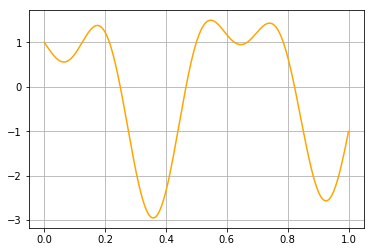

In [2]:
duration = 1*second

t_sim = np.arange(0,duration/second,0.0001)
f_out = sin(4*pi*t_sim) - sin(7*pi*t_sim) + cos(3*pi*t_sim)

plot(t_sim, f_out, color='orange')
grid()

First, we will recreate the driven network where the driving function $f_D = f_{out}$ (Fig 2B). (For this and the next network, specific values and equations are adapted from [DePasquale, Churchland, and Abbott, 2016](https://arxiv.org/abs/1601.07620)).

In [3]:
# Recreate Figure 2B (fD = fout)
start_scope()

tau_syn = 2*ms
tau_m = 10*ms
v_r = -65*mV
v_t = -55*mV
refrac = 2*ms
Ibias = 10*mV
g = 25*mV
N = 1000
duration = 1*second
gf = 17 / sqrt(N)
mu = -57 / N

eqs_neurons_B = '''
dv/dt = (v_r - v + g*(Js + uD * fD) + Ibias)/tau_m : volt (unless refractory)
dJs/dt = -Js/tau_syn : 1 # synaptic current multiplied by synapse weight
ds/dt = -s/tau_syn : 1   # normalized synaptic current

fD = sin(4*pi*Hz*t) - sin(7*pi*Hz*t) + cos(3*pi*Hz*t) : 1
uD : 1
'''

# Define neuron group
neurons_B = NeuronGroup(N, eqs_neurons_B, threshold='v>v_t', 
                        reset='v=v_r', refractory=refrac, method='euler')
neurons_B.v = v_r
neurons_B.uD = '2*rand() - 1'

# Define random fast synapses
S_B = Synapses(neurons_B, neurons_B, '''Jfast : 1''', on_pre='''
                Js+=Jfast
                s+=1''')
S_B.connect(p=0.1)
S_B.Jfast = '''gf * randn() + mu'''

# Define monitors
mon_B = SpikeMonitor(neurons_B)
Js_mon_B = StateMonitor(neurons_B, 'Js', record=True)
v_mon_B = StateMonitor(neurons_B, 'v', record=True)
s_mon_B = StateMonitor(neurons_B, 's', record=True)

run(duration)

WARNING    /opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/jovyan/.cache/cython/brian_extensions/_cython_magic_264a06b9056d01074f353565692c89b3.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]


We can check the functioning of the network before decoding its output by viewing the spike raster, the voltage trace from a random neuron, and the normalized and raw synaptic currents received by the same neuron.

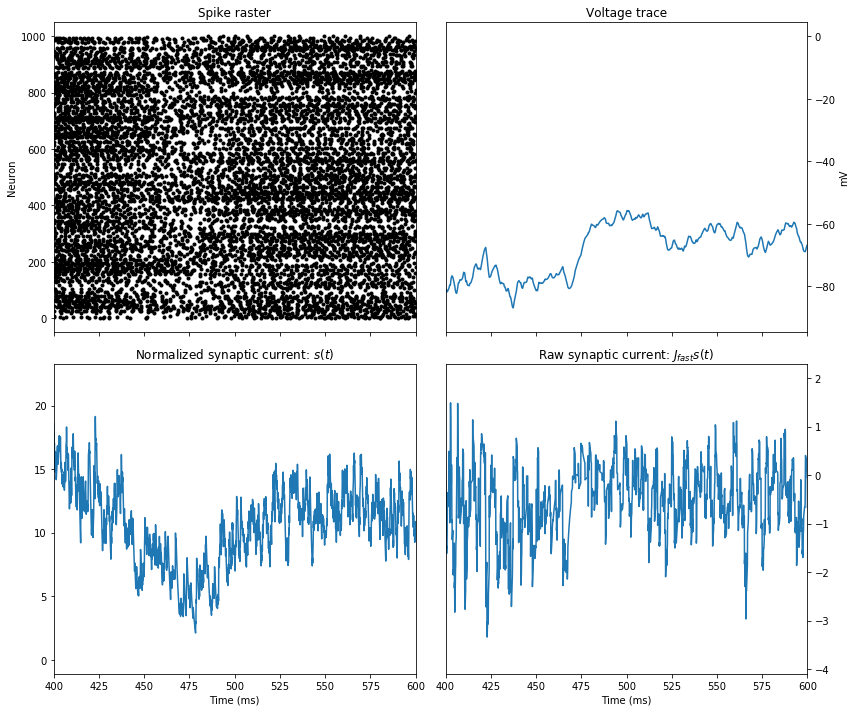

In [4]:
idx = 11

v_trace_B = v_mon_B.v[idx]
v_trace_B[array(mon_B.spike_trains()[idx]/defaultclock.dt,dtype=int)] = 0

fig, ax = subplots(2,2,sharex=True,figsize=(12,10))
ax[0][0].plot(mon_B.t/ms, mon_B.i,'k.')
ax[0][0].set_title('Spike raster')
ax[0][0].set_ylabel('Neuron')
ax[0][1].plot(v_mon_B.t/ms, v_trace_B/mV)
ax[0][1].set_title('Voltage trace')
ax[0][1].set_ylabel('mV')
ax[0][1].yaxis.tick_right()
ax[0][1].yaxis.set_label_position("right")
ax[1][0].plot(s_mon_B.t/ms, s_mon_B.s[idx])
ax[1][0].set_title('Normalized synaptic current: $s(t)$')
ax[1][0].set_xlabel('Time (ms)')
ax[1][1].plot(Js_mon_B.t/ms, Js_mon_B.Js[idx])
ax[1][1].set_title('Raw synaptic current: $J_{fast}s(t)$')
ax[1][1].yaxis.tick_right()
ax[1][1].set_xlabel('Time (ms)')

xlim([400,600])
tight_layout()

Next, we change the driving function to $f_D = f_{out} + \tau_{s} \frac{df_{out}}{dt}$ in order to correct for synaptic low-pass filtering and its associated phase delay; this network recreates Fig. 2C.
### This is an opportunity to vary parameters!
Particularly, we can vary $\tau_{s}$ in the above equation, coded below as `tau_drive`. We will see that larger $\tau_s$ values (or at least $\tau_{s} = 20ms$) perform better. Decoding weights $\textbf{w}$ (described below) have been calculated for $\tau_s = [2,10,20,100]ms$; otherwise, new decoding weights must be computed (an extremely costly operation).

In [5]:
# Recreate Figure 2C (fD = fout + tau * dfout/dt)
start_scope()

tau_syn = 2*ms
tau_drive = 10*ms # ADJUST THIS VALUE
tau_m = 20*ms
v_r = -65*mV
v_t = -55*mV
refrac = 2*ms
Ibias = 10*mV
g = 25*mV
N = 1000
duration = 1*second
gf = 17 / sqrt(N)
mu = -57 / N

eqs_neurons_C = '''
dv/dt = (v_r - v + g*(Js + uD * fD) + Ibias)/tau_m : volt (unless refractory)
dJs/dt = -Js/tau_syn : 1
ds/dt = -s/tau_drive : 1
uD : 1

fout = sin(4*pi*Hz*t) - sin(7*pi*Hz*t) + cos(3*pi*Hz*t) : 1
dfoutdt = pi * (4*cos(4*pi*Hz*t) - 7*cos(7*pi*Hz*t) - 3*sin(3*pi*Hz*t)) * Hz : Hz
fD = fout + dfoutdt * tau_drive : 1
'''

neurons_C = NeuronGroup(N, eqs_neurons_C, threshold='v>v_t', reset='v=v_r', refractory=refrac, method='euler')
neurons_C.v = v_r
neurons_C.uD = '2*rand() - 1'

S_C = Synapses(neurons_C, neurons_C, '''Jfast : 1''', on_pre='''
                Js+=Jfast
                s+=1''')
S_C.connect(p=0.1)
S_C.Jfast = '''gf * randn() + mu'''

mon_C = SpikeMonitor(neurons_C)
Js_mon_C = StateMonitor(neurons_C, 'Js', record=True)
v_mon_C = StateMonitor(neurons_C, 'v', record=True)
s_mon_C = StateMonitor(neurons_C, 's', record=True)

run(duration)

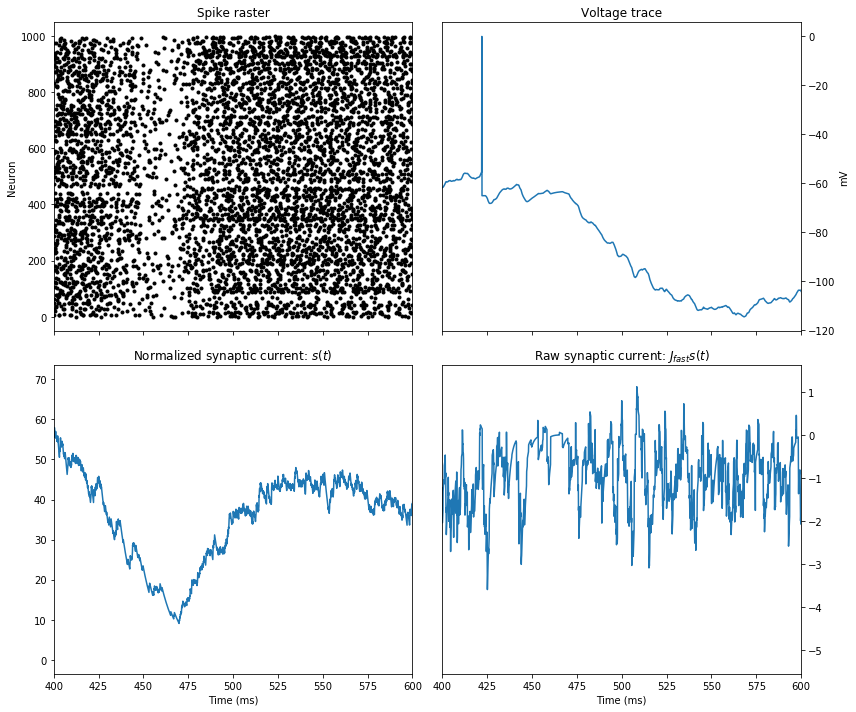

In [6]:
idx = 18

v_trace_C = v_mon_C.v[idx]
v_trace_C[array(mon_C.spike_trains()[idx]/defaultclock.dt,dtype=int)] = 0

fig, ax = subplots(2,2,sharex=True,figsize=(12,10))
ax[0][0].plot(mon_C.t/ms, mon_C.i,'k.')
ax[0][0].set_title('Spike raster')
ax[0][0].set_ylabel('Neuron')
ax[0][1].plot(v_mon_C.t/ms, v_trace_C/mV)
ax[0][1].set_title('Voltage trace')
ax[0][1].set_ylabel('mV')
ax[0][1].yaxis.tick_right()
ax[0][1].yaxis.set_label_position("right")
ax[1][0].plot(s_mon_C.t/ms, s_mon_C.s[idx])
ax[1][0].set_title('Normalized synaptic current: $s(t)$')
ax[1][0].set_xlabel('Time (ms)')
ax[1][1].plot(Js_mon_C.t/ms, Js_mon_C.Js[idx])
ax[1][1].set_title('Raw synaptic current: $J_{fast}s(t)$')
ax[1][1].yaxis.tick_right()
ax[1][1].set_xlabel('Time (ms)')

xlim([400,600])
tight_layout()

Now, we find optimal decoding weight matrices $\textbf{w}$ for each of the synaptic output matrices $\textbf{s}$ such that we can reconstruct the output function
$$ f_{out}(t) \approx ws(t)$$
for each of the driving inputs $f_D = f_{out}$ and $f_D = f_{out} + \tau \frac{df_{out}}{dt}$ (corresponding to $w_B$ and $w_C$, respectively, with subscript based on subsection of Figure 2 in the original paper). Since these least-squares optimizations take significant time (5 to 10 minutes each on my lab desktop), we will only calculate them if weights haven't already been saved.

In [7]:
def weighted_sum(s, *w):
    return dot(w,array(s)).ravel()

In [8]:
savename = 'w_tau_drive_' + str(int(tau_drive/ms)) + 'ms.npz'
try:
    w_saved = load(savename)
    wB = w_saved['wB']
    wC = w_saved['wC']
except FileNotFoundError as e:
    print(str(e) + ' - Calculating new weights...')
    
    w = rand(N)
    %time wB, _ = curve_fit(weighted_sum, s_mon_B.s, f_out, p0=w)
    print('wB done.')
    %time wC, _ = curve_fit(weighted_sum, s_mon_C.s, f_out, p0=w)
    print('wC done.')
    
    # savename = 'w_' + time.strftime("%m_%d_%y_%H%M%S")
    savez(savename, wB=wB, wC=wC, g=g, gf=gf, mu=mu)
except KeyError as e:
    print(str(e) + ' - Calculating new weights...')
    
    w = rand(N)
    %time wB, _ = curve_fit(weighted_sum, s_mon_B.s, f_out, p0=w)
    print('wB done.')
    %time wC, _ = curve_fit(weighted_sum, s_mon_C.s, f_out, p0=w)
    print('wC done.')
    
    savez(savename, wB=wB, wC=wC, g=g, gf=gf, mu=mu)

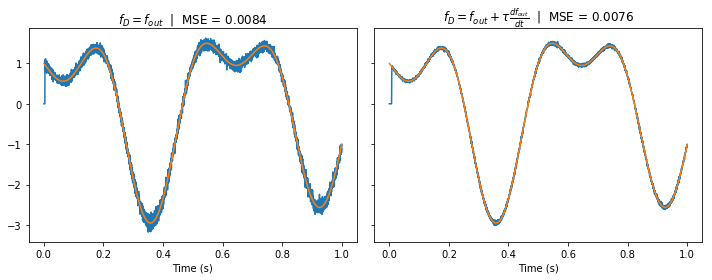

In [9]:
wBs = dot(wB, s_mon_B.s)
mseB = mean((f_out - wBs)**2)
wCs = dot(wC, s_mon_C.s)
mseC = mean((f_out - wCs)**2)

fig, ax = subplots(1,2,sharex=True, sharey=True, figsize=(10,4))
ax[0].plot(s_mon_B.t/second, wBs, s_mon_B.t/second, f_out)
ax[0].set_title('$f_D = f_{out}$  |  MSE = ' + str(mseB)[0:6])
ax[1].plot(s_mon_C.t/second, wCs, s_mon_B.t/second, f_out)
ax[1].set_title('$f_D = f_{out} + \\tau \\frac{df_{out}}{dt}$  |  MSE = ' + str(mseC)[0:6])
ax[0].set_xlabel('Time (s)') 
ax[1].set_xlabel('Time (s)')
tight_layout()

Now, I implement part D of Figure 2, using the spike-coding model described in Machens and Deneve, 2016, and network details/parameters described in [Boerlin, Machens, and Deneve, 2013](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003258).

In [10]:
a = 25*mV
b = -55*mV
T = a + b
v_reset = b - a
v_rest = b
lambda_v = 20 * Hz
lambda_d = 10 * Hz
lambda_s = 0.1* Hz
sigma_s  = 0.01
sigma_v  = 0
gD = 100 * mV
tau_syn = 10 * ms 

nu = 0
mu = 1e-6

N = 1000
J = 1

duration = 1*second

In [11]:
eqs_deneve = '''
dv/dt = lambda_v * (v_rest - v) + gD *(syn_s - syn_f + (ffw * c)) / tau_syn : volt
dsyn_s/dt = - syn_s * lambda_d : 1
syn_f : 1

fout = (sin(4*pi*Hz*t) - sin(7*pi*Hz*t) + cos(3*pi*Hz*t)) : 1
dfoutdt = pi * (4*cos(4*pi*Hz*t) - 7*cos(7*pi*Hz*t) - 3*sin(3*pi*Hz*t)) * Hz : Hz
fD = (fout + dfoutdt / lambda_s) : 1

c = fD - xhat : 1

ffw : 1
xhat : 1
'''

In [12]:
halfN = int(N/2)

Gamma = -1*ones((J,N))
Gamma[:,:halfN] = ((0.1-0.06)*np.random.sample((J,halfN)) + 0.06)*np.random.binomial(1,0.7,(J,halfN))
Gamma[:,halfN:] = ((0.06-0.1)*np.random.sample((J,halfN)) - 0.06)*np.random.binomial(1,0.7,(J,halfN))

Omega_f = dot(Gamma.T, Gamma) + mu * (lambda_d/Hz)**2 * identity(N)
Omega_s = dot(dot(Gamma.T, lambda_d/Hz * identity(J)),Gamma)

In [13]:
start_scope()

Gamma = a * Gamma / T
Omega_f = a * Omega_f / T
Omega_s = a * Omega_s / T

neur = NeuronGroup(N, eqs_deneve, threshold='v > T', reset='v = v_reset', method='euler')
neur.ffw = Gamma
neur.v = v_reset

W_s = Synapses(neur, neur, 'omega : 1', on_pre='syn_s += omega')
W_s.connect()
W_s.omega = Omega_s.flatten()

# Brian doesn't natively allow a delta function as a synaptic input, so we recreate it by
# adding the synaptic weight then subtracting it after one dt
W_f = Synapses(neur, neur, 'omega : 1', on_pre={'pre_add': 'syn_f += omega',
                                                'pre_sub': 'syn_f -= omega'})
W_f.connect()
W_f.omega = Omega_f.flatten()
W_f.pre_sub.delay = defaultclock.dt

out = NeuronGroup(1, '''dx/dt = -lambda_d * x + syn * Hz: 1
                        syn : 1''', method='euler')

neur.xhat = out.x

syn_out = Synapses(neur, out, 'wts : 1', on_pre='syn += wts')
syn_out.connect()
syn_out.wts = Gamma.flatten()

mon_D = SpikeMonitor(neur)
sf_mon_D = StateMonitor(neur, 'syn_f', record=True)
ss_mon_D = StateMonitor(neur, 'syn_s', record=True)
out_mon_D = StateMonitor(out, 'x', record=True)
v_mon_D = StateMonitor(neur, 'v', record=True)

run(duration)

(0, 1)

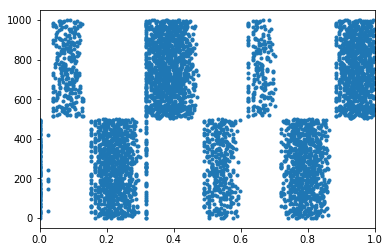

In [14]:
plot(mon_D.t/second, mon_D.i, '.')
xlim([0,1])

The spike raster shows that this network spikes much less often than the rate-coding networks.

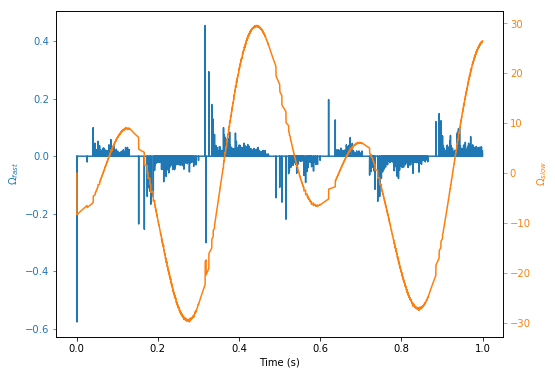

In [15]:
idx = 9

fig, axL = subplots(figsize=(8,6))
axL.plot(sf_mon_D.t/second, sf_mon_D.syn_f[idx])
axL.set_xlabel('Time (s)')
axL.set_ylabel('$\Omega_{fast}$', color='C0')
axL.tick_params('y', colors='C0')

axR = axL.twinx()
axR.plot(ss_mon_D.t/second, ss_mon_D.syn_s[idx], 'C1')
axR.set_ylabel('$\Omega_{slow}$', color='C1')
axR.tick_params('y', colors='C1')

Above are the fast ($\Omega_{fast}$) and slow ($\Omega_{slow}$) synaptic inputs to a particular neuron.

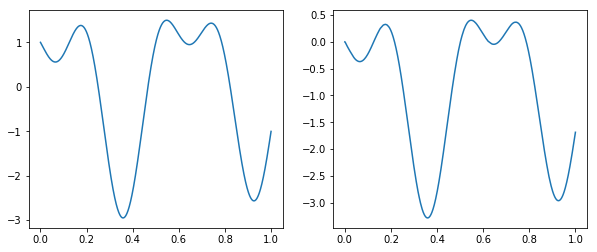

In [16]:
t_sim = np.arange(0,duration/second,0.0001)
f_out = sin(4*pi*t_sim) - sin(7*pi*t_sim) + cos(3*pi*t_sim)

fig = figure(figsize=(10,4))
subplot(121)
plot(t_sim, f_out)
subplot(122)
plot(out_mon_D.t/second, out_mon_D.x[0])

Above are plots of the target function and the initially decoded output. The decoded output need only be adjusted with a y-offset and a small multiplicative constant.

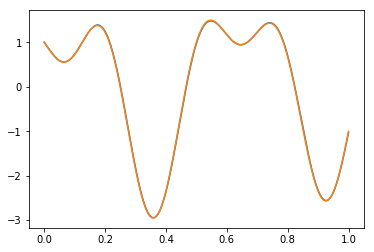

In [17]:
xhat_adj = out_mon_D.x[0] * 1.2 + 1

plot(out_mon_D.t/second, xhat_adj, t_sim, f_out)

In [18]:
mseD = mean((f_out - xhat_adj)**2)

Finally, we can recreate Figure 2 from the Abbott 2016 paper.

Text(0.5, 0.98, 'Driven networks approximating target output')

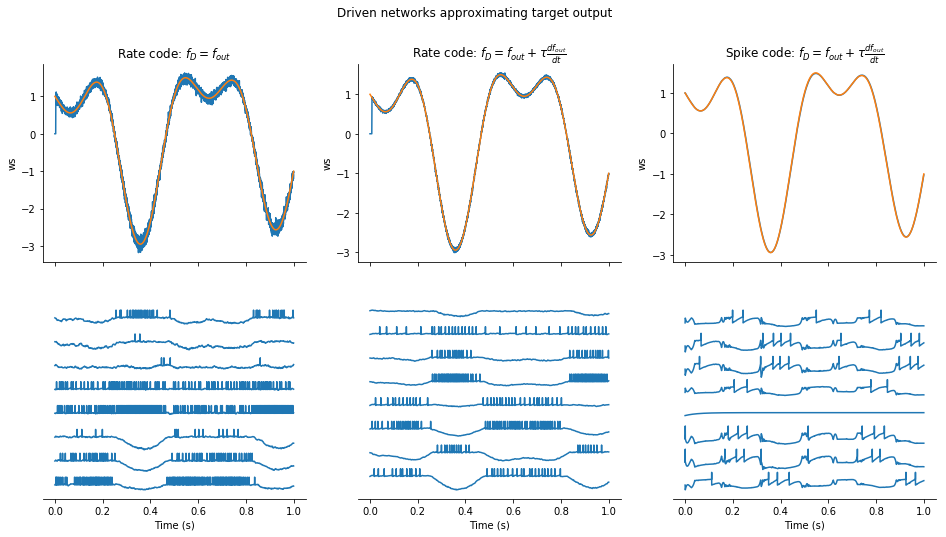

In [19]:
rand_idx = np.random.randint(N, size=8)
v_traces_B = zeros((len(rand_idx),len(v_mon_B.v[0])))
v_traces_C = zeros((len(rand_idx),len(v_mon_C.v[0])))
v_traces_D = zeros((len(rand_idx),len(v_mon_D.v[0])))

for i, idx in enumerate(rand_idx):
    v_traces_B[i,:] = v_mon_B.v[idx]
    v_traces_B[i,array(mon_B.spike_trains()[idx]/defaultclock.dt,dtype=int)] = 0
    v_traces_C[i,:] = v_mon_C.v[idx]
    v_traces_C[i,array(mon_C.spike_trains()[idx]/defaultclock.dt,dtype=int)] = 0
    v_traces_D[i,:] = v_mon_D.v[idx]
    v_traces_D[i,array(mon_D.spike_trains()[idx]/defaultclock.dt,dtype=int)] = 30*mV


fig, ax = subplots(2,3,figsize=(16,8),sharex=True)
ax[0][0].plot(s_mon_B.t/second, wBs, t_sim, f_out)
ax[0][1].plot(s_mon_C.t/second, wCs, t_sim, f_out)
ax[0][2].plot(out_mon_D.t/second, xhat_adj, t_sim, f_out)
for i in range(len(rand_idx)):
    ax[1][0].plot(v_mon_B.t/second, (v_traces_B[i] + 0.2*i)/mV, color='C0')
    ax[1][1].plot(v_mon_C.t/second, (v_traces_C[i] + 0.2*i)/mV, color='C0')
    ax[1][2].plot(v_mon_D.t/second, (v_traces_D[i] + 0.2*i)/mV, color='C0')
ax[0][0].spines['top'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][2].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][2].spines['right'].set_visible(False)
ax[1][0].get_yaxis().set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][1].get_yaxis().set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][2].get_yaxis().set_visible(False)
ax[1][2].spines['top'].set_visible(False)
ax[1][2].spines['left'].set_visible(False)
ax[1][2].spines['right'].set_visible(False)
ax[0][0].set_ylabel('ws')
ax[0][1].set_ylabel('ws')
ax[0][2].set_ylabel('ws')
ax[1][0].set_xlabel('Time (s)')
ax[1][1].set_xlabel('Time (s)')
ax[1][2].set_xlabel('Time (s)')
ax[0][0].set_title('Rate code: $f_D = f_{out}$')
ax[0][1].set_title('Rate code: $f_D = f_{out} + \\tau \\frac{df_{out}}{dt}$')
ax[0][2].set_title('Spike code: $f_D = f_{out} + \\tau \\frac{df_{out}}{dt}$')
suptitle('Driven networks approximating target output')
#tight_layout()

In [20]:
print('{:^13s}|| {:^20s}| {:^20s}| {:^20s}'.format('','Fig. 2B','Fig. 2C', 'Fig. 2D'))
print('-'*80)
print('{:^13s}|| {:^20f}| {:^20f}| {:^20f}'.format('MSE',mseB, mseC, mseD))


             ||       Fig. 2B       |       Fig. 2C       |       Fig. 2D       
--------------------------------------------------------------------------------
     MSE     ||       0.008435      |       0.007664      |       0.000369      


### Part B - Discussion

In the section **Spike coding to improve accuracy**, the authors analyze some differences between rate-coding and spike-coding networks. Particularly, they argue that the spike-coding network is a more accurate, precise, and robust encoding scheme than the rate-coding network. My implementation of the three networks supports this; the two rate-coding networks have similar mean squared errors, while the spike-coding network is orders of magnitude more accurate (see above). Equally importantly, there is no learning/optimization required in the spike-coding network; all synaptic and readout weights arise from the mathematics. On the other hand, the rate-coding networks require (comparatively) costly least-squares optimization of the readout weights to translate normalized synaptic currents to encoded output. In terms of simulation and implementation, a system with fixed, precomputed, near-optimal weights is extremely attractive. These observations are also supported by the math, wherein the error of the rate-coding network is order $\frac{1}{\sqrt{N}}$ while the spike-coding error is order $\frac{1}{N}$, where $N$ is number of neurons.

The authors characterize both network types as based on the changing of neuron firing rates to encode a target output function. While this is absolutely the case for the rate-coding network, this seems misleading for the spike-coding network. Not only is instantaneous firing rate of a neuron in the network highly variable both between and within a trial (especially in a case with sparse spiking), it is the coordinated firing of _many_ neurons that underlies the spike-coding network. Rather than encoding information in rates, the network encodes information in the particular spike timing between various neurons. This can be interpreted through the lens of rate (see Eq. 3 from Boerlin, Machens, and Deneve, 2013), but it is more informative to understand it as based upon population-wide spike timing. Understanding the network this way better dispels the idea that neurons are noisy building blocks, instead suggesting that variability in timing or rate is a feature of the network; this is a particularly important contribution of this work.

Spike-coding networks, and all their accuracy gains, are enabled by a dense and strong set of synaptic connections, tightly coupling slower-timescale excitation with (near-)instantaneous inhibition. This density/complexity also provides robustness to the system, by rapidly adjusting entire population dynamics on the fly to respond to errant or missing spikes. Whether this synaptic density is a positive or a necessary evil is quite debatable. If anything, it creates an interesting and important trade-off between number of neurons and number of synapses. To reach the same accuracy, a rate-coding network required $N^2$ neurons compared to the spike-coding network's $N$ neurons; however, the synaptic density and complexity is much higher in the spike-coding network than in the rate-coding network. In other words, for a given accuracy, the models describe two ends of a trade-off between number of neurons and complexity of connectivity.

Understanding this trade-off is important for implementing these networks. For example, the choice of model would be strongly affected by the properties of the software or hardware used for implementation. Hardware with limited synaptic capability, for example, might perform better with a rate-coding model while hardware with few neurons but complex connectivity might excel with a spike-coding model. It would be particularly interesting to compare the models on a system where both the number of neurons and the synaptic capabilities are limited. This would be a good test of the idea behind the IFAT, wherein all connectivity is serialized through a single synapse at a speed much faster than biological timescales; if that serialized synaptic paradigm could handle the number of synapses (and their varying timescales) required in the spike-coding model, it would be extremely powerful for even a small number of neurons.

Ultimately, I agree with the authors; both network types have their merits, but the spike-coding network is especially interesting and promising for its accuracy. The fact that its error is order $\frac{1}{N}$, as opposed to the $\frac{1}{\sqrt{N}}$ order error of the rate-coding network, is particularly noteworthy.

## Additional References

Boerlin, M., Machens, C. K., & Denève, S. (2013). Predictive Coding of Dynamical Variables in Balanced Spiking Networks. PLoS Computational Biology, 9(11). https://doi.org/10.1371/journal.pcbi.1003258

DePasquale, B., Churchland, M. M., & Abbott, L. F. (2016). Using Firing-Rate Dynamics to Train Recurrent Networks of Spiking Model Neurons, 1–17. https://arxiv.org/abs/1601.07620
